# Quick example of WL Classification
## using Valen's warm up and our virtual label model
This example tries to show the usage of the classes and methods
proposed here to show classification with weakly labeled datasets.

We will use the model proposed by Valen and their warm up prior to 20 epochs
with our method (We will use the

In [1]:
# Importing general libraries
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Importing specific classes and functions
from utils.weakener import Weakener

#Importing drawing tools
import matplotlib.pyplot as plt

#importing dataloaders
from datasets.openml_datasets import OpenML_Dataset
from datasets.torch_datasets import Torch_Dataset
from models.model import MLP,mlp_valen
from utils.trainig_testing import train_model,evaluate_model,train_and_evaluate
from utils.losses import EMLoss, CELoss

from utils.warm_up import warm_up_benchmark

In [2]:
# DS stores the dataset and its related attributes
DS = Torch_Dataset('mnist')
train_x, train_y, test_x, test_y = DS.get_data()
# WL stores pocesses relative to the Weakening process
WL = Weakener(DS.num_classes)


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%
100.0%
100.0%
100.0%


In [3]:
# Generation of the mixing matrix according to the model
#  we've chosen.
WL.generate_M(model_class='pll')

In [4]:
# We generate the weak labels (this step is optional as WL.virtual_labels(train_y) can do it)
z, w = WL.generate_weak(train_y)

z is the numerical encodig of the weak label while w is a one-hot
representation of that variable. z also encodes the row of the M matrix
for that given weak label.

Let's consider the example of partial label learning for the iris dataset.
labels are encoded as ```{0: '011', 1: '101', 2: '110', 3: '111'}```
so having an isntance with `z=3` means `w=[1,1,1]`, i.e., the weak label contains every label.

In [5]:
# We generate the weak labels (this step is optional as WL.virtual_labels(train_y) can do it)
WL.virtual_matrix()
#And we generate the virtual labels
WL.virtual_labels(train_y)


#we make a new dataloader because valen takes the weak label instead of the
# virtual label.
indices = torch.arange(0,len(train_x))
valen_train_data = TensorDataset(train_x, w ,train_y,indices)
valen_train_loader = DataLoader(valen_train_data, batch_size=364, shuffle=True)


WL.virtual_labels(train_y)
DS.include_weak(WL.v)
# Once we have our dataset with all the labels we need we can create the dataloaders.
trainloader, testloader = DS.get_dataloader()

In [6]:
mlp = mlp_valen(DS.num_features,DS.num_features,DS.num_classes)

In [7]:
mlp = warm_up_benchmark(mlp,trainloader,testloader)

Begin warm-up, warm up epoch 10
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
After warm up, test acc: 0.0001
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
After warm up, test acc: 0.0002
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]

In [8]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = CELoss()

mlp

mlp_valen(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=784, out_features=784, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=784, out_features=784, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=784, out_features=10, bias=True)
)

In [9]:
# Train and evaluate the MLP on the training data, test data, and get the results
mlp, results = train_and_evaluate(mlp, trainloader, testloader,
                                  optimizer, loss_fn, num_epochs=10)

# Print the results
print('Train Loss:', results['train_loss'][-1])
print('Train Accuracy:', results['train_acc'][-1])
print('Test Accuracy:', results['test_acc'][-1])

Epoch 1/10: Train Loss: 758.7087, Train Acc: 0.5722, Test Acc: 0.8059
Epoch 2/10: Train Loss: 1.5549, Train Acc: 0.7116, Test Acc: 0.5684
Epoch 3/10: Train Loss: 3.7199, Train Acc: 0.4854, Test Acc: 0.4446
Epoch 4/10: Train Loss: -57.5241, Train Acc: 0.1789, Test Acc: 0.1037
Epoch 5/10: Train Loss: -24481.2957, Train Acc: 0.1956, Test Acc: 0.2137
Epoch 6/10: Train Loss: -480486.8294, Train Acc: 0.2271, Test Acc: 0.2665
Epoch 7/10: Train Loss: -2669822.1460, Train Acc: 0.2212, Test Acc: 0.1891
Epoch 8/10: Train Loss: -8269771.6664, Train Acc: 0.2142, Test Acc: 0.1960
Epoch 9/10: Train Loss: -18730638.9984, Train Acc: 0.2085, Test Acc: 0.1947
Epoch 10/10: Train Loss: -35582234.4390, Train Acc: 0.2084, Test Acc: 0.2073
Train Loss: -35582234.438960254
Train Accuracy: tensor(0.2084, dtype=torch.float64)
Test Accuracy: tensor(0.2073, dtype=torch.float64)


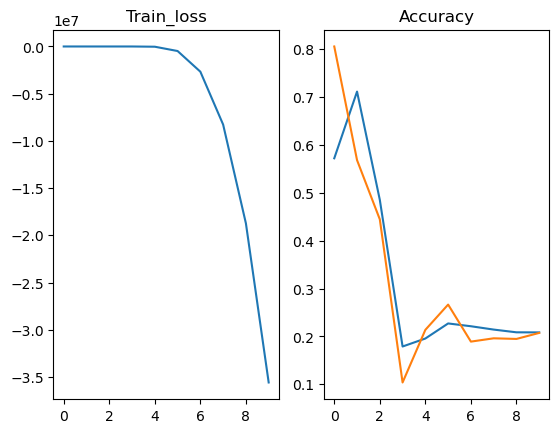

In [10]:
figure, axis = plt.subplots(1, 2)

# For Sine Function
axis[0].plot(results['train_loss'])
axis[0].set_title("Train_loss")

# For Cosine Function
axis[1].plot(results['train_acc'])
axis[1].plot(results['test_acc'])
axis[1].set_title("Accuracy")
plt.show()

In [11]:
#We need to include this Weak Labels into the dataset,
# we need to include w to mantain the coherence. z will only be used
# in the loss for the EM
DS.include_weak(WL.v)
# Once we have our dataset with all the labels we need we can create the dataloaders.
trainloader, testloader = DS.get_dataloader()

print(len(testloader.dataset))
print(len(trainloader.dataset))

10000
60000


Now we have a trainloader containing (X,v,y) and a testloader containig (X,y)
so we can just establish our model and train it.

In [12]:
# Create an instance of the MLP class
mlp = MLP(input_size=DS.num_features, hidden_sizes=[20],
          output_size=DS.num_classes, dropout_p=0.5)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = CELoss()

train_losses,train_accs=train_model(mlp,trainloader,optimizer,
                                    loss_fn,num_epochs=10)

# Print the final training loss and accuracy
print('Final Training Loss: {:.4f}'.format(train_losses[-1]))
print('Final Training Accuracy: {:.4f}'.format(train_accs[-1]))

Epoch 1/10 - Loss: 1.3633 - Accuracy: 0.5506
Epoch 2/10 - Loss: 0.9731 - Accuracy: 0.6562
Epoch 3/10 - Loss: 0.8150 - Accuracy: 0.6679
Epoch 4/10 - Loss: 0.7005 - Accuracy: 0.6780
Epoch 5/10 - Loss: 0.6704 - Accuracy: 0.6805
Epoch 6/10 - Loss: 0.5717 - Accuracy: 0.6859
Epoch 7/10 - Loss: 0.5179 - Accuracy: 0.6853
Epoch 8/10 - Loss: 0.3713 - Accuracy: 0.6879
Epoch 9/10 - Loss: 0.3279 - Accuracy: 0.6816
Epoch 10/10 - Loss: 0.1738 - Accuracy: 0.6732
Final Training Loss: 0.1738
Final Training Accuracy: 0.6732


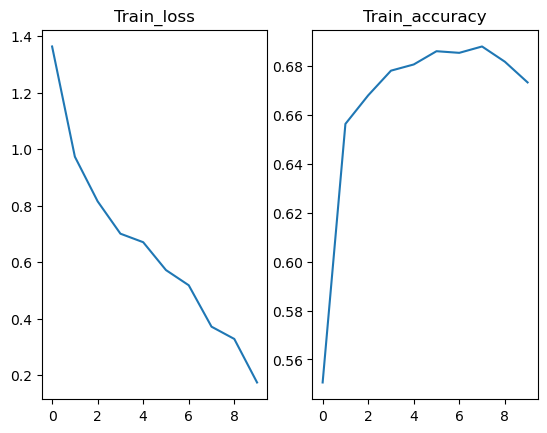

In [13]:
figure, axis = plt.subplots(1, 2)

# For Sine Function
axis[0].plot(train_losses)
axis[0].set_title("Train_loss")

# For Cosine Function
axis[1].plot(train_accs)
axis[1].set_title("Train_accuracy")
plt.show()

In [14]:
# Create an instance of the MLP class
mlp = MLP(input_size=DS.num_features, hidden_sizes=[20],
          output_size=DS.num_classes, dropout_p=0.5)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)
loss_fn = CELoss()

# Train and evaluate the MLP on the training data, test data, and get the results
mlp, results = train_and_evaluate(mlp, trainloader, testloader,
                                  optimizer, loss_fn, num_epochs=10)

# Print the results
print('Train Loss:', results['train_loss'][-1])
print('Train Accuracy:', results['train_acc'][-1])
print('Test Accuracy:', results['test_acc'][-1])

Epoch 1/10: Train Loss: 1.3260, Train Acc: 0.5491, Test Acc: 0.8506
Epoch 2/10: Train Loss: 0.9074, Train Acc: 0.6604, Test Acc: 0.8749
Epoch 3/10: Train Loss: 0.7520, Train Acc: 0.6798, Test Acc: 0.8855
Epoch 4/10: Train Loss: 0.6373, Train Acc: 0.6895, Test Acc: 0.8849
Epoch 5/10: Train Loss: 0.5914, Train Acc: 0.6969, Test Acc: 0.8866
Epoch 6/10: Train Loss: 0.4833, Train Acc: 0.6930, Test Acc: 0.8825
Epoch 7/10: Train Loss: 0.4162, Train Acc: 0.6960, Test Acc: 0.8804
Epoch 8/10: Train Loss: 0.3163, Train Acc: 0.6906, Test Acc: 0.8840
Epoch 9/10: Train Loss: 0.3200, Train Acc: 0.6922, Test Acc: 0.8837
Epoch 10/10: Train Loss: 0.2070, Train Acc: 0.6907, Test Acc: 0.8811
Train Loss: 0.2069994517623777
Train Accuracy: tensor(0.6907, dtype=torch.float64)
Test Accuracy: tensor(0.8811, dtype=torch.float64)


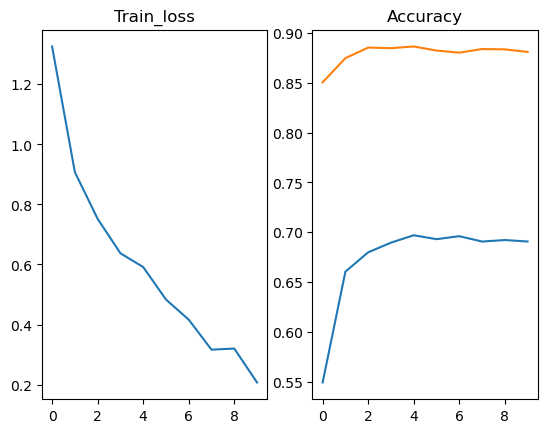

In [15]:
figure, axis = plt.subplots(1, 2)

# For Sine Function
axis[0].plot(results['train_loss'])
axis[0].set_title("Train_loss")

# For Cosine Function
axis[1].plot(results['train_acc'])
axis[1].plot(results['test_acc'])
axis[1].set_title("Accuracy")
plt.show()